# sciRED tutorial: Identifying stimulation signals in a stimulated PBMC dataset
In this tutorial, we'll use sciRED to analyze a benchmark dataset comprising 10x droplet-based scRNA-seq PBMC data from 8 Lupus patients before and after a 6-hour treatment with interferon (IFN)-β.

sciRED enables the discovery of interpretable factors, automatically aligns factors with known covariates, and provides a thorough set of summary statistics to assess the interpretability of identified factors. We implement a four-step approach to characterizing gene expression programs: (1) Removing confounding effects and using rotations to maximize factor interpretability (2) Calculating associations statistics to map factors with known covariates, (3) Highlighting unexplained factors that may indicate hidden biological phenomena, and (4) Determining the genes and biological processes represented by unexplained factors.

sciRED example modules (sciRED.examples) include preprocessing and visualization functions specific to the example datatsets

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels as sm

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

from sciRED import glm
from sciRED import rotations as rot
from sciRED import ensembleFCA as efca
from sciRED import metrics as met

from sciRED.utils import preprocess as proc
from sciRED.utils import visualize as vis
from sciRED.utils import corr

from sciRED.examples import ex_preprocess as exproc
from sciRED.examples import ex_visualize as exvis


/Users/delaram/.conda/envs/scLMM/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
np.random.seed(10)
NUM_COMPONENTS = 30
NUM_GENES = 2000
NUM_COMP_TO_VIS = 3

sciRED main functions take in the gene expression data as a numpy.ndarray data object. Here we import an AnnData file (.h5ad) and then subset the data to include highly varible genes. Depending on the dataset, the number of genes to include could be around 2000, 5000 and 10000.   

In [4]:
data_file_path = '/Users/delaram/Desktop/PBMC_Lupus_Kang8vs8_data.h5ad'
data = exproc.import_AnnData(data_file_path)
data, gene_idx = proc.get_sub_data(data, num_genes=NUM_GENES) # subset the data to num_genes HVGs
y, genes, num_cells, num_genes = proc.get_data_array(data)
y_sample, y_stim, y_cell_type, y_cluster  = exproc.get_metadata_humanPBMC(data)  ### this function is specific to the human PBMC dataset

29065 2000


Here we define colors and legend for later visualizations. 

In [5]:
colors_dict_humanPBMC = exvis.get_colors_dict_humanPBMC(y_sample, y_stim, y_cell_type) ## these functions are specific to the human PBMC dataset
plt_legend_sample = exvis.get_legend_patch(y_sample, colors_dict_humanPBMC['sample'] )
plt_legend_stim = exvis.get_legend_patch(y_stim, colors_dict_humanPBMC['stim'] )
plt_legend_cell_type = exvis.get_legend_patch(y_cell_type, colors_dict_humanPBMC['cell_type'] )

**Step 1: Factor discovery:** Since we are interested in sample-specific simulation signals, including _sample_ as a covariate inside GLM could remove interesting biological signals. Therefore, we only include library size in sciRED's design matrix to be regressed out. As explained in the manuscript, we recommend extracting the **pearson** residuals by default for later factor decompoisition. However, our benchmark analysis indicated that sciRED is not sensitive to choice of residual. Other options are _response_ and _deviance_ residual types.

In [6]:

#### design matrix - library size only
x = proc.get_library_design_mat(data, lib_size='nCount_originalexp')

### fit GLM to each gene
glm_fit_dict = glm.poissonGLM(y, x)
resid_pearson = glm_fit_dict['resid_pearson'] 
print('pearson residuals: ', resid_pearson.shape) # numpy array of shape (num_genes, num_cells)
print('y shape: ', y.shape) # (num_cells, num_genes)
y = resid_pearson.T # (num_cells, num_genes)
print('y shape: ', y.shape) # (num_cells, num_genes)


time to fit the model:  38.67363119125366
pearson residuals:  (2000, 29065)
y shape:  (29065, 2000)
y shape:  (29065, 2000)


We then apply PCA to the extracted residuals. PCA factors are then rotated (varimax or promax) to improve interpretibility. 

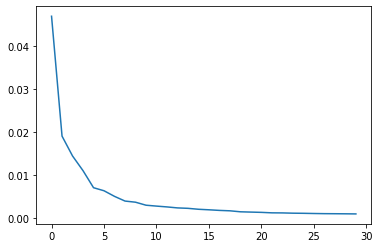

In [7]:
####################################
#### Running PCA on the data ######
####################################
### using pipeline to scale the data first
pipeline = Pipeline([('scaling', StandardScaler()), ('pca', PCA(n_components=NUM_COMPONENTS))])
pca_scores = pipeline.fit_transform(y)
pca = pipeline.named_steps['pca']
pca_loading = pca.components_ 
pca_loading.shape #(factors, genes)

plt.plot(pca.explained_variance_ratio_)

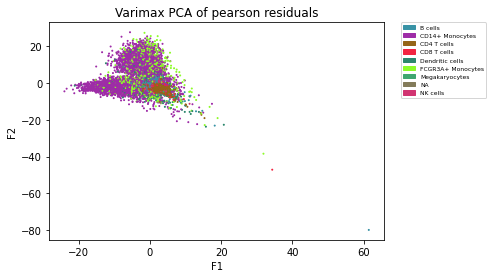

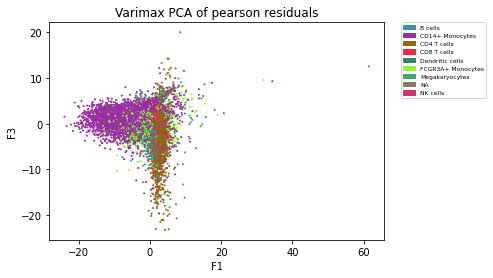

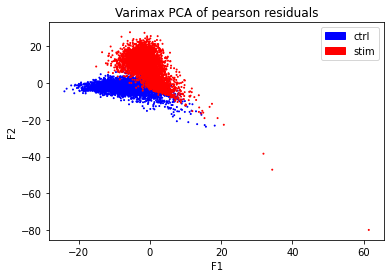

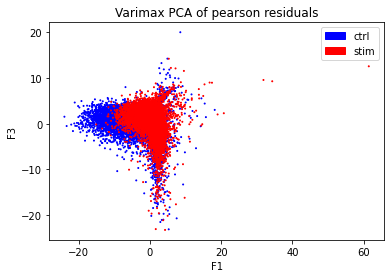

In [8]:
######## Applying varimax rotation to the factor scores
rotation_results_varimax = rot.varimax(pca_loading.T) ## returns a dictionary of the rotated loading matrix and the rotation matrix
varimax_loading = rotation_results_varimax['rotloading']
pca_scores_varimax = rot.get_rotated_scores(pca_scores, rotation_results_varimax['rotmat'])

### visualizing the varimax-PCA first few factors 
title = 'Varimax PCA of pearson residuals'
### annotating the cells with the cell type
vis.plot_pca(pca_scores_varimax, NUM_COMP_TO_VIS, 
               cell_color_vec= colors_dict_humanPBMC['cell_type'],
               legend_handles=True,
               title=title,
               plt_legend_list=plt_legend_cell_type)

### annotating the cells with the stimulation condition
vis.plot_pca(pca_scores_varimax, NUM_COMP_TO_VIS, 
               cell_color_vec= colors_dict_humanPBMC['stim'],
               legend_handles=True,
               title=title,
               plt_legend_list=plt_legend_stim)

In [9]:
varimax_loading_df = pd.DataFrame(varimax_loading)
varimax_loading_df.columns = ['F'+str(i) for i in range(1, varimax_loading_df.shape[1]+1)]
varimax_loading_df.index = genes
varimax_loading_df.head() ## the first few rows of the rotated loading matrix

,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,...,F21,F22,F23,F24,F25,F26,F27,F28,F29,F30
HES4,0.027974,0.112424,0.008192,-0.003963,-0.001724,0.038521,-0.022954,0.008002,-0.016603,0.000484,...,-0.022141,0.015430,-0.010796,-0.006889,-0.008809,0.043780,-0.003829,-0.021577,-0.008868,0.060089
ISG15,0.033537,0.133342,0.021422,0.000459,0.001652,0.007693,-0.039156,-0.001311,0.022057,-0.005040,...,-0.006819,-0.006390,0.000911,-0.004266,-0.012602,0.034637,-0.006614,0.001117,-0.008880,0.024804
TNFRSF18,0.021626,0.007059,-0.010071,-0.007217,-0.134683,0.009449,-0.007471,-0.057428,-0.012126,-0.026691,...,-0.024639,-0.005505,-0.020617,0.018792,-0.124535,-0.006413,0.030680,0.021645,-0.033800,0.033086
TNFRSF4,0.037952,-0.014766,0.000501,0.004757,-0.007884,0.039636,-0.003323,-0.005401,0.004170,-0.039571,...,0.003772,0.000156,0.003185,-0.002184,-0.088375,0.014545,0.029163,0.056315,-0.110357,-0.002231
SDF4,-0.002004,-0.001146,-0.020616,0.003401,-0.017139,0.003776,-0.004850,-0.002778,-0.009342,-0.012222,...,-0.012639,0.004323,-0.000179,0.004296,-0.009523,0.003032,0.002777,0.003596,-0.019620,-0.004101


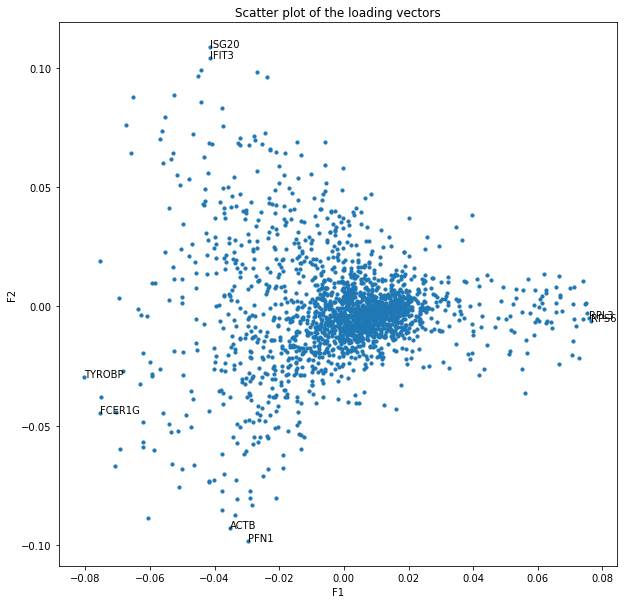

In [11]:
##### Setting the factor scores an loadings to be used in step-2 based on Varimax factors
factor_loading = rotation_results_varimax['rotloading']
factor_scores = pca_scores_varimax

covariate_vec = y_stim
covariate_level = np.unique(covariate_vec)[1]

#### plot the loading vectors - here each data point represents a gene
vis.plot_factor_loading(pca_loading.T, genes, 0, 1, fontsize=10, 
                    num_gene_labels=2,
                    title='Scatter plot of the loading vectors', 
                    label_x=True, label_y=True)


**Step 2: Factor-Covariate Association**: To identify factors that explain a specific covariate, sciRED employs an ensemble classifier as a second step. We apply four machine learning classifiers to predict covariate labels based on the cell-specific factor weights. Feature importance scores are obtained from each classifier are then scaled based on one out of three scaling methods, and averaged to generate a consensus association score. The consensus scores for every combination of covariate and factor are aggregated into the factor-covariate association table (FCAT) and visualized in a heatmap. 
The FCAT function takes-in the cell-level labels for each covariate. The resulting tables for each covariate are then concatenated and visualized as a heatmap.  

In [12]:
%%capture
####################################
#### FCAT score calculation ######
####################################

### FCAT needs to be calculated for each covariate separately
fcat_sample = efca.FCAT(y_sample, factor_scores, scale='standard', mean='arithmatic')
fcat_stim = efca.FCAT(y_stim, factor_scores, scale='standard', mean='arithmatic')
fcat_cell_type = efca.FCAT(y_cell_type, factor_scores, scale='standard', mean='arithmatic')


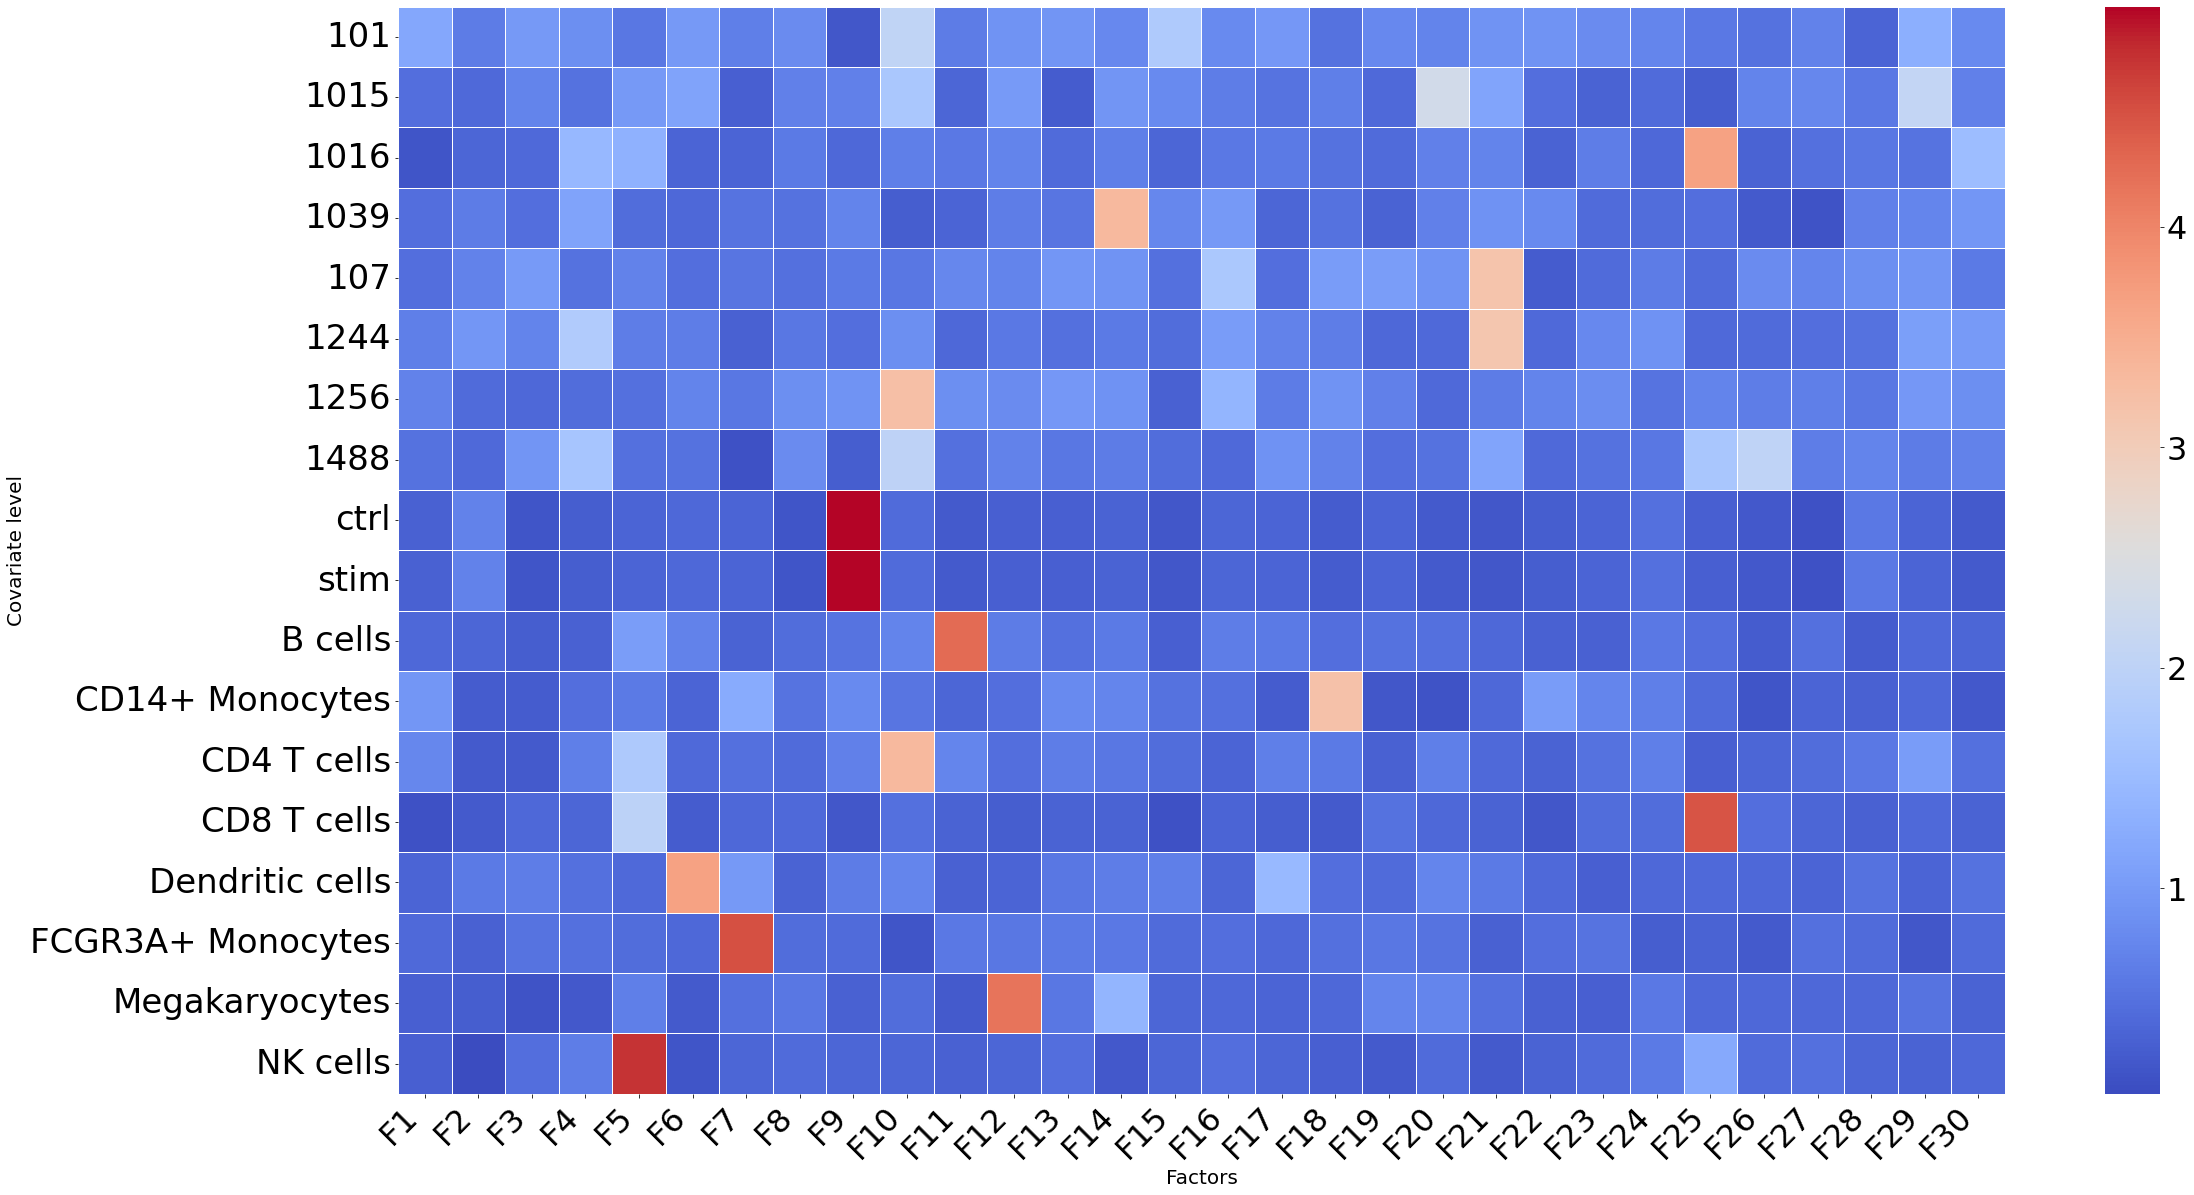

In [14]:
### concatenate FCAT table for protocol and cell line
fcat = pd.concat([fcat_sample, fcat_stim, fcat_cell_type], axis=0)
fcat = fcat[fcat.index != 'NA'] ### remove the rownames called NA from table

vis.plot_FCAT(fcat, title='', color='coolwarm',
              x_axis_fontsize=20, y_axis_fontsize=20, title_fontsize=22,
              x_axis_tick_fontsize=32, y_axis_tick_fontsize=34)



Significant vs non-significant associations between factors and covariates are determined using a threshold automatically obtained using Otsu’s method. This threshold can assist users in defining the number of inferred factors (K). For example, if a considerable proportion of factors fail to align with any covariates, it may prompt the user to reduce K. 

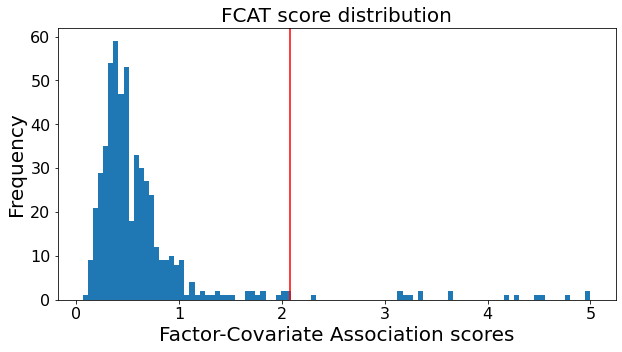

In [15]:
### using Otsu's method to calculate the threshold
threshold = efca.get_otsu_threshold(fcat.values.flatten())

vis.plot_histogram(fcat.values.flatten(),
                   xlabel='Factor-Covariate Association scores',
                   title='FCAT score distribution',
                   threshold=threshold)

percent_matched_fact:  43.33
percent_matched_cov:  88.89


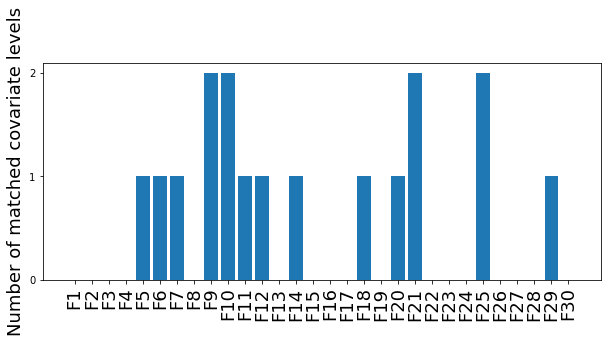

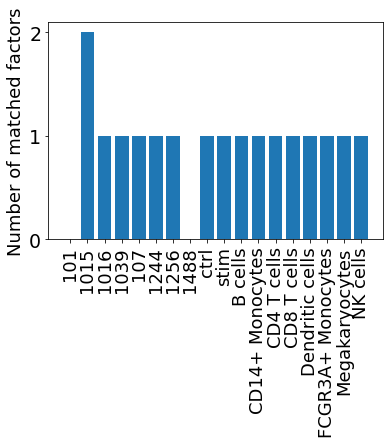

In [16]:

## rownames of the FCAT table
all_covariate_levels = fcat.index.values
matched_factor_dist, percent_matched_fact = efca.get_percent_matched_factors(fcat, threshold)
matched_covariate_dist, percent_matched_cov = efca.get_percent_matched_covariates(fcat, threshold=threshold)
print('percent_matched_fact: ', percent_matched_fact)
print('percent_matched_cov: ', percent_matched_cov)
vis.plot_matched_factor_dist(matched_factor_dist)
vis.plot_matched_covariate_dist(matched_covariate_dist, 
                                covariate_levels=all_covariate_levels)

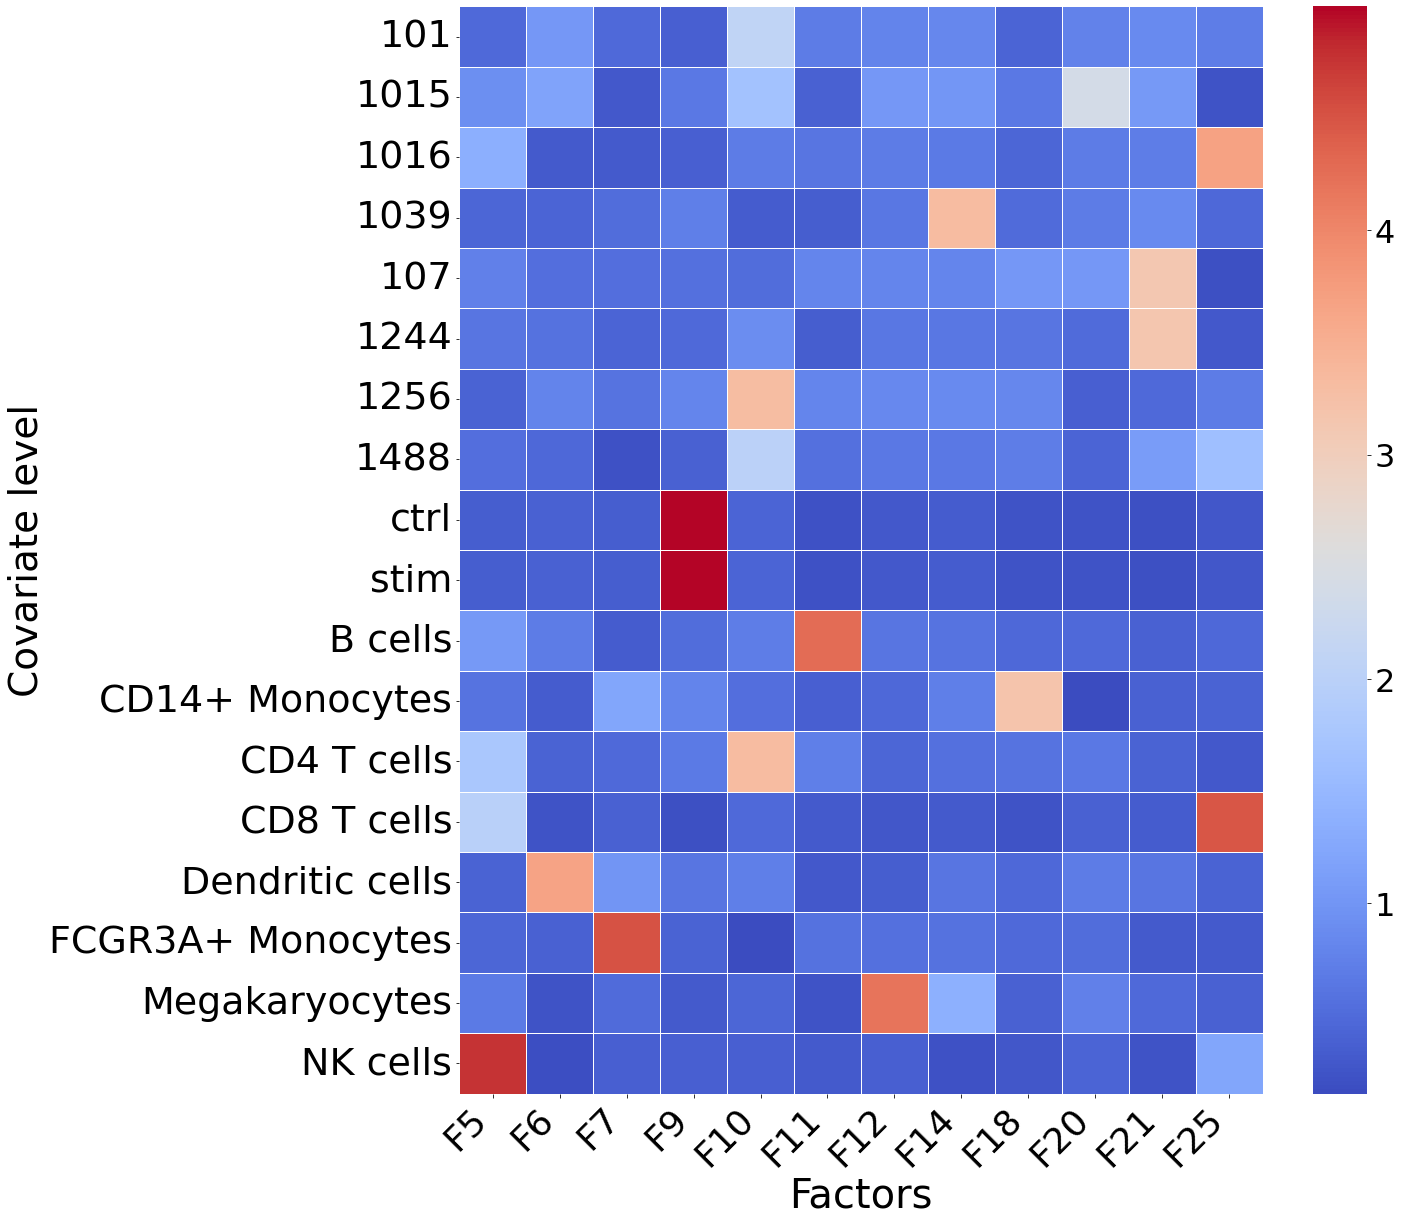

In [19]:
### select the factors that are matched with any covariate level
matched_factor_index = np.where(matched_factor_dist>0)[0] 
fcat_matched = fcat.iloc[:,matched_factor_index] 
x_labels_matched = fcat_matched.columns.values
vis.plot_FCAT(fcat_matched, x_axis_label=x_labels_matched, title='', color='coolwarm',
                                 x_axis_fontsize=40, y_axis_fontsize=39, title_fontsize=40,
                                 x_axis_tick_fontsize=36, y_axis_tick_fontsize=38, 
                                 save=False, save_path='../Plots/mean_importance_df_matched_PBMC.pdf')


We can check the correlation between the factors and the library size which was regressed out

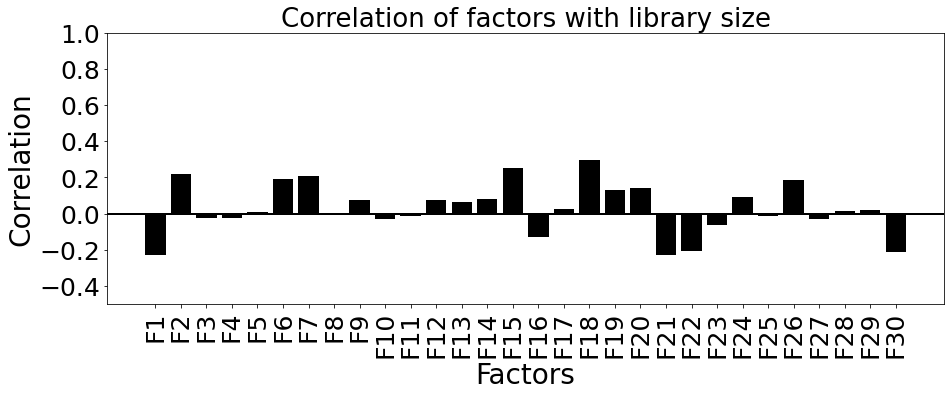

In [20]:

factor_libsize_correlation = corr.get_factor_libsize_correlation(factor_scores, library_size = data.obs.nCount_originalexp)
vis.plot_factor_cor_barplot(factor_libsize_correlation, 
             title='Correlation of factors with library size', 
             y_label='Correlation', x_label='Factors')

You can also exclude the technical covariates (such as sample) from the heatmap depending on your biological questions.

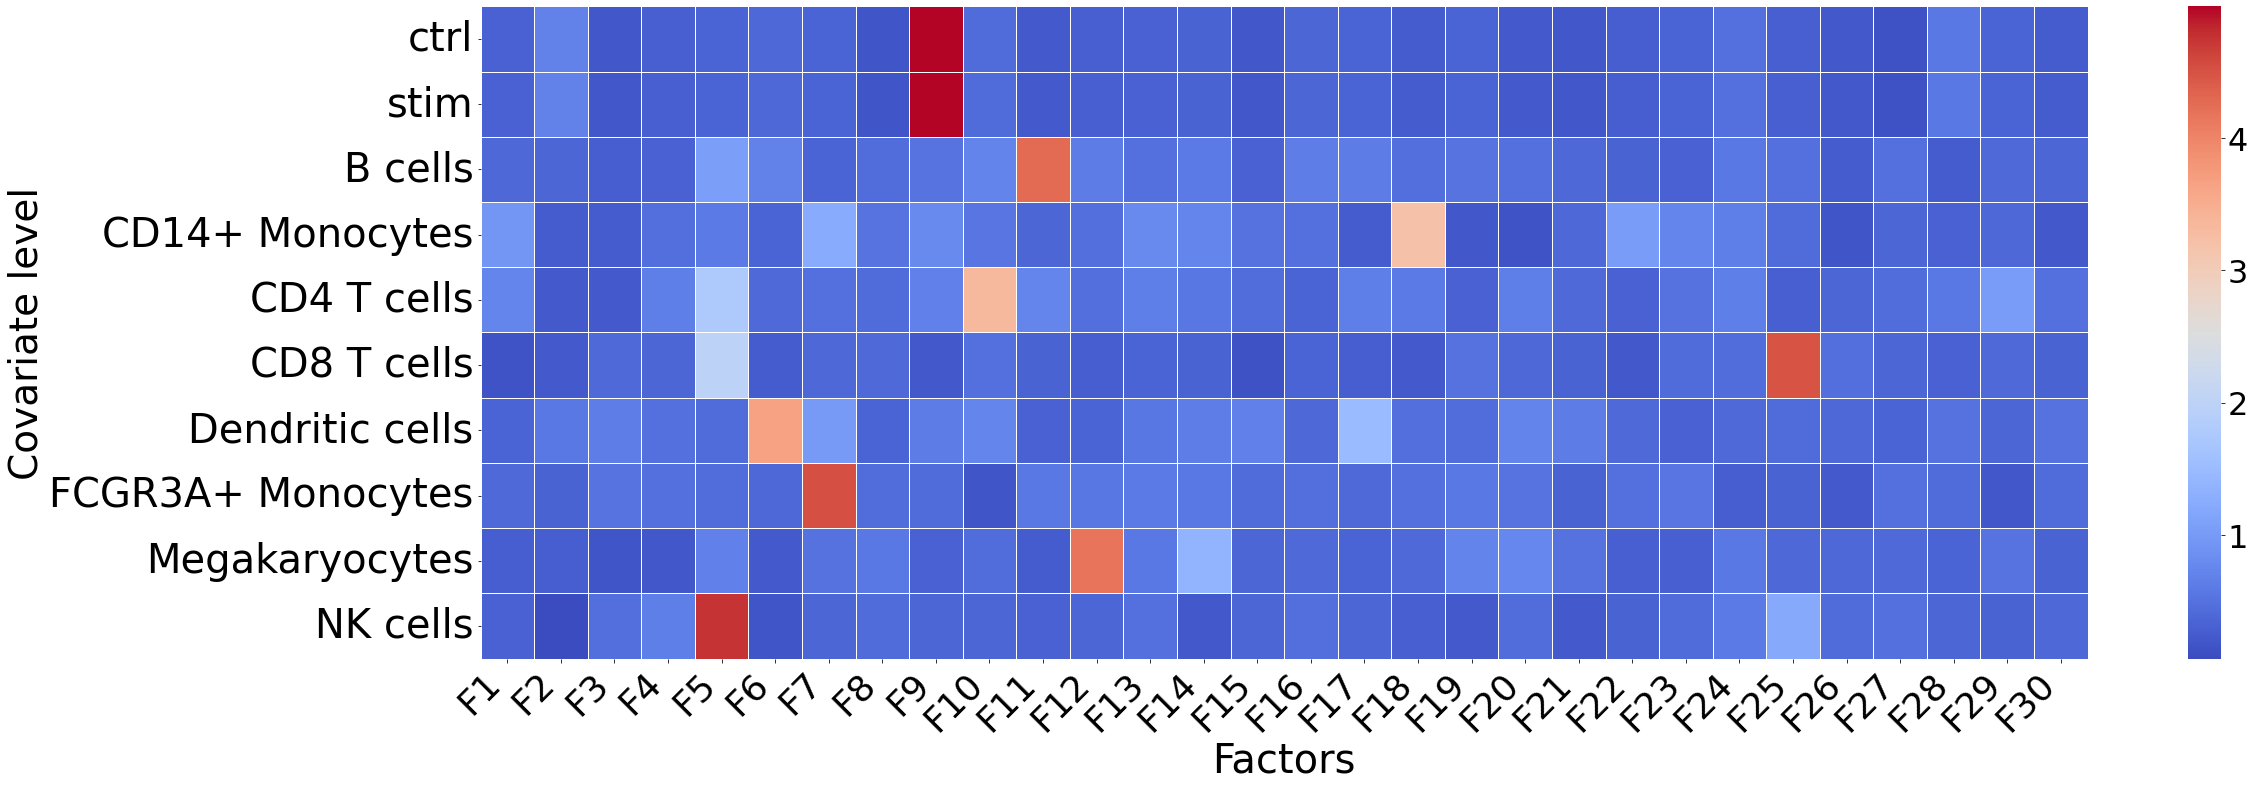

In [21]:

### concatenate FCAT table for protocol and cell line
fcat = pd.concat([fcat_stim, fcat_cell_type], axis=0)
fcat = fcat[fcat.index != 'NA'] ### remove the rownames called NA from table

vis.plot_FCAT(fcat, title='', color='coolwarm',
              x_axis_fontsize=40, y_axis_fontsize=39, title_fontsize=40,
              x_axis_tick_fontsize=36, y_axis_tick_fontsize=40, 
              save=False, save_path='../Plots/mean_importance_df_matched_PBMC.pdf')

Here we can evaluate which factors had the highest association score with our covariate level of interest (stimulation status in this case)

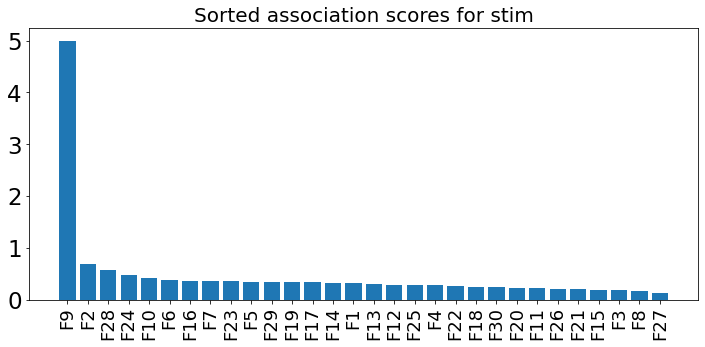

In [18]:
stim_fcat_sorted_scores, stim_factors_sorted = vis.plot_sorted_factor_FCA_scores(fcat, 'stim')

**Step 3: Interpretability scores:** The third step of sciRED involves quantifying the interpretability of identified factors. We defined four categories of metrics: separability, effect size, specificity, and homogeneity which are presented as the FIST table. 

In [20]:

####################################
#### Bimodality scores
# silhouette_score = met.kmeans_bimodal_score(factor_scores, time_eff=True) ## this can take a while. You can skip this step, and rely on bimodality_index alone as a measure of bimodality.
bimodality_index = met.bimodality_index(factor_scores)

# bimodality_score = np.mean([silhouette_score, bimodality_index], axis=0)
bimodality_score = bimodality_index  ## faster alternative to the above lines

#### Effect size
factor_variance = met.factor_variance(factor_scores)

## Specificity
simpson_fcat = met.simpson_diversity_index(fcat)

### Homogeneity (how well-mixed the factors are given the covariate)
asv_cell_type = met.average_scaled_var(factor_scores, covariate_vector=y_cell_type, mean_type='arithmetic')
asv_stim = met.average_scaled_var(factor_scores, covariate_vector=y_stim, mean_type='arithmetic')
asv_sample = met.average_scaled_var(factor_scores, y_sample, mean_type='arithmetic')


<Figure size 576x2304 with 0 Axes>

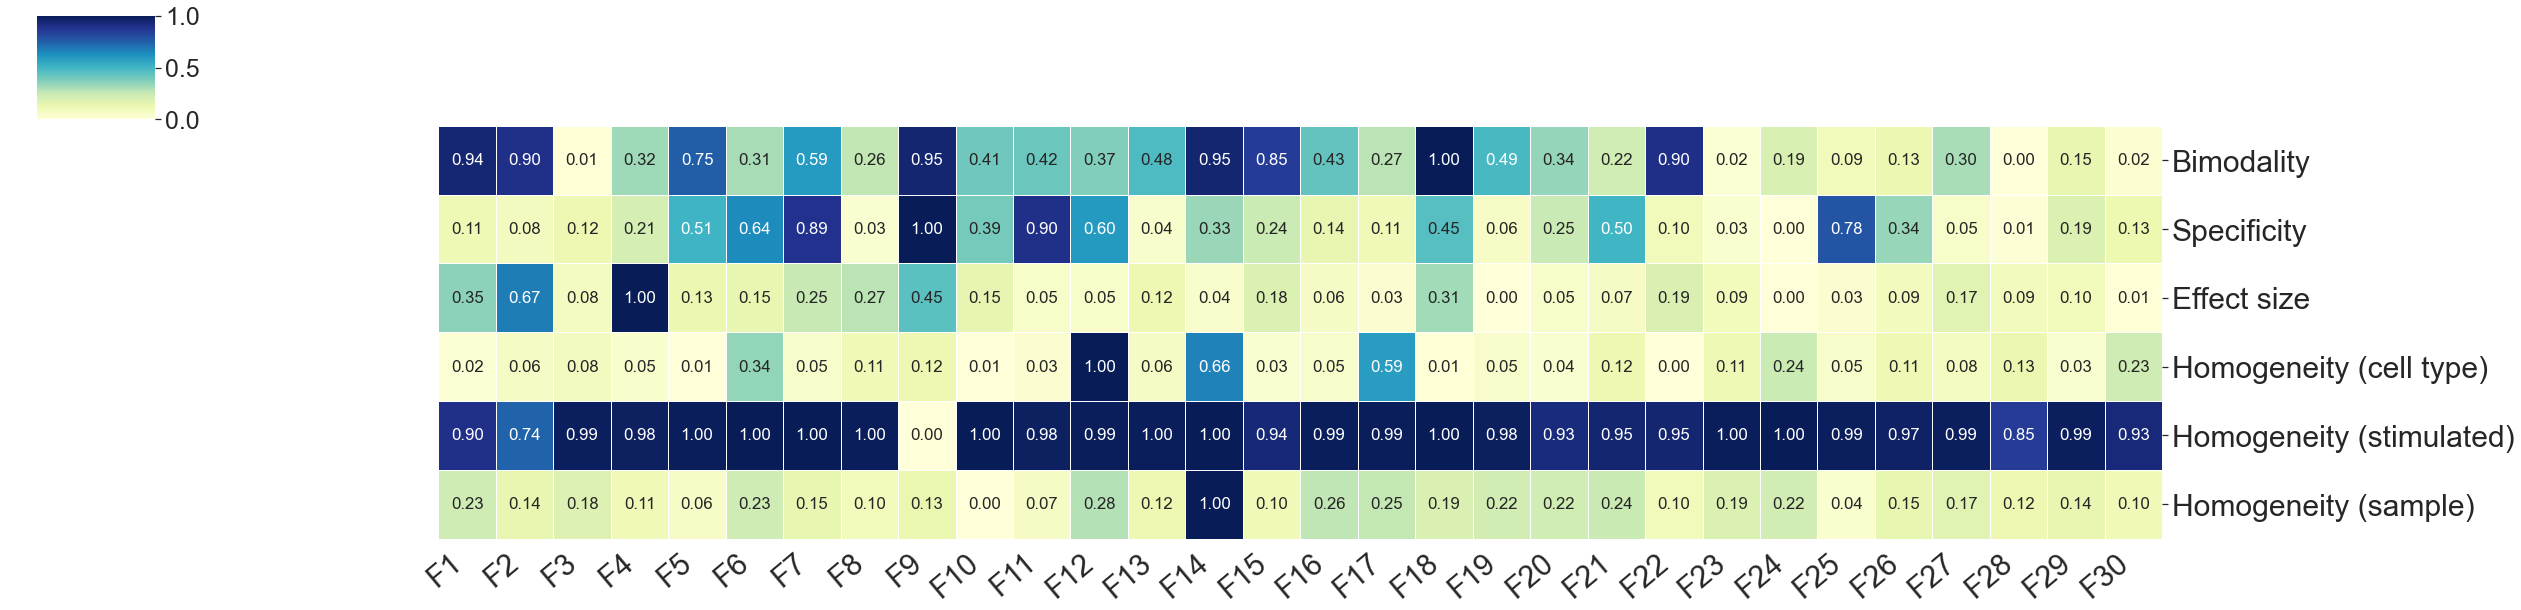

In [21]:

########### create factor-interpretibility score table (FIST) ######
metrics_dict = {'Bimodality':bimodality_score, 
                    'Specificity':simpson_fcat,
                    'Effect size': factor_variance,
                    'Homogeneity (cell type)':asv_cell_type,
                    "Homogeneity (stimulated)":asv_stim,
                    'Homogeneity (sample)':asv_sample}

fist = met.FIST(metrics_dict)
vis.plot_FIST(fist, title='Scaled metrics for all the factors')
### subset the first 15 factors of fist dataframe
#vis.plot_FIST(fist.iloc[0:15,:])
#vis.plot_FIST(fist.iloc[matched_factor_index,:])

